# 热身环节 💪
温馨提示：在运行这个notebook
前，建议你先备份一份，以便对照输出是否在预期内。

此外，如果你遇到视频中某些参数和 jupyter notebook 不同的情况，请以后者为准，因为经过了最新迭代与勘误。

有时候版本更新可能会改变一些约定，若出错请你删除之前生成的任务文件，再重新运行相应的命令

更新时间：2023/01/17

In [9]:
# 新建一个文件夹专门用来放教程类产生的文件
import os
if not os.path.exists("MyTutorial"):
    os.makedirs("MyTutorial")

In [10]:
!python demo/image_demo.py  demo/demo.jpg \
    checkpoints/yolov3_mobilenetv2_8xb24-320-300e_coco.py \
    checkpoints/yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth \
    --out-file MyTutorial/demo_result.jpg\
    --device cpu

local loads checkpoint from path: checkpoints/yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth
/home/sanbu/anaconda3/envs/mmlab2/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:170: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


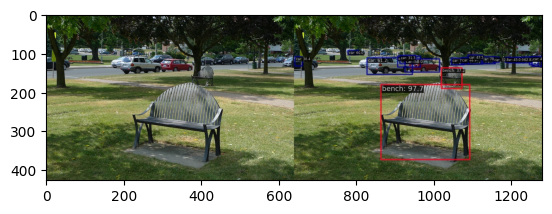

In [16]:
from matplotlib import pyplot as plt
import mmcv
plt.imshow(mmcv.imread("MyTutorial/demo_result.jpg",channel_order='rgb'))

In [1]:
import cv2
import mmcv
from mmcv.transforms import Compose
from mmengine.utils import track_iter_progress
from mmdet.registry import VISUALIZERS
from mmdet.utils import register_all_modules
from mmdet.apis import init_detector, inference_detector

# Register all modules in mmdet into the registries
register_all_modules()

# Specify the path to model config and checkpoint file
config_file = 'checkpoints/yolov3_mobilenetv2_8xb24-320-300e_coco.py'
checkpoint_file = 'checkpoints/yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth'

# Build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# Test a video and show the results
# Build test pipeline
model.cfg.test_dataloader.dataset.pipeline[0].type = 'LoadImageFromNDArray'
test_pipeline = Compose(model.cfg.test_dataloader.dataset.pipeline)

# Init visualizer
try:
    visualizer = VISUALIZERS.build(model.cfg.visualizer)
except:
    from mmengine.visualization import Visualizer
    visualizer = Visualizer.get_current_instance()
    
# The dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta

video_reader = mmcv.VideoReader('demo/demo.mp4')
cv2.namedWindow('video', 0)
for frame in track_iter_progress(video_reader):
    result = inference_detector(model, frame, test_pipeline=test_pipeline)
    visualizer.add_datasample(
        name='video',
        image=frame,
        data_sample=result,
        draw_gt=False,
        show=False)
    frame = visualizer.get_image()
    mmcv.imshow(frame, 'video',wait_time=1)
cv2.destroyAllWindows()

local loads checkpoint from path: checkpoints/yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth
[                                                  ] 0/67, elapsed: 0s, ETA:

/home/sanbu/anaconda3/envs/mmlab2/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:170: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


[                                  ] 1/67, 0.6 task/s, elapsed: 2s, ETA:   111s

/home/sanbu/anaconda3/envs/mmlab2/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:709: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  ' the drawn bbox may not be in the image', UserWarning)
/home/sanbu/anaconda3/envs/mmlab2/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:779: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  ' the drawn polygon may not be in the image', UserWarning)


[>>                                ] 5/67, 2.3 task/s, elapsed: 2s, ETA:    27s

/home/sanbu/anaconda3/envs/mmlab2/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:469: UserWarning: Warning: The text is out of bounds, the drawn text may not be in the image
  ' the drawn text may not be in the image', UserWarning)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 67/67, 6.9 task/s, elapsed: 10s, ETA:     0s


# 一、数据集的构建

## 1.1 官方数据集

#本目录下，在另外一个终端中运行如下代码
python tools/misc/download_dataset.py --dataset-name coco2017 --save-dir data/coco

In [7]:
!gedit tools/misc/download_dataset.py

In [ ]:
#注释文件中的对应部分
#为什么不要test？因为 test_dataloader = val_dataloader
coco2017=[
    'http://images.cocodataset.org/zips/train2017.zip',
    'http://images.cocodataset.org/zips/val2017.zip',
    # 'http://images.cocodataset.org/zips/test2017.zip',
    # 'http://images.cocodataset.org/zips/unlabeled2017.zip',
    'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',  # noqa
    # 'http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip',  # noqa
    # 'http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip',  # noqa
    # 'http://images.cocodataset.org/annotations/image_info_test2017.zip',  # noqa
    # 'http://images.cocodataset.org/annotations/image_info_unlabeled2017.zip',  # noqa
]

In [1]:
!ls data/coco

annotations		      test2017.zip  train2017.zip  val2017.zip
annotations_trainval2017.zip  train2017     val2017


In [2]:
!ls data/coco/annotations

instances_train2017.json  instances_val2017.json


In [ ]:
"""
annotations: 对应标注文件夹
	├── instances_train2017.json		: 对应目标检测、分割任务的
	├── instances_val2017.json			: 对应目标检测、分割任务的验证集标注文件
	├── captions_train2017.json			: 对应图像描述的训练集标注文件
	├── captions_val2017.json			: 对应图像描述的验证集标注文件
	├── person_keypoints_train2017.json	: 对应人体关键点检测的训练集标注文件
	└── person_keypoints_val2017.json	: 对应人体关键点检测的验证集标注文件夹
"""

## 1.2 自制数据集

数据集下载地址：https://universe.roboflow.com/brad-dwyer/aquarium-combined/dataset/3

In [ ]:
# 其他可参考转换器：
!wget https://raw.githubusercontent.com/d246810g2000/mmdetection/main/train_val_data_split_coco.py

In [3]:
!ls data/mycoco/datasets

'Aquarium Combined.v3-video-inference.coco'
'Aquarium Combined.v3-video-inference.coco.zip'
'Aquarium Combined.v3-video-inference.voc'
'Aquarium Combined.v3-video-inference.voc.zip'


In [4]:
!tree data/mycoco/fish_coco/

data/mycoco/fish_coco/
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── _annotations.coco.json
│   ├── IMG_2289_jpeg_jpg.rf.ed11415683226df2655cc1522a0ae231.jpg
│   ├── IMG_2301_jpeg_jpg.rf.2650b6b2f9acb407987b5990c0e4f59c.jpg
│   ├── IMG_2319_jpeg_jpg.rf.7486294fcddd01edacb8ef01fc5fe66e.jpg
│   ├── IMG_2347_jpeg_jpg.rf.1d5edf4aa874ecf4fd754f35f475b05b.jpg
│   ├── IMG_2354_jpeg_jpg.rf.f2eaef0d423d7cd8a9b100acc893f422.jpg
│   ├── IMG_2371_jpeg_jpg.rf.be25eb0e39e2e96b776fdb6ee946cf31.jpg
│   ├── IMG_2379_jpeg_jpg.rf.85f04fa30755de265b80dcf5c37331fa.jpg
│   ├── IMG_2380_jpeg_jpg.rf.71b6cb388bdc584ac765dc453656903c.jpg
│   ├── IMG_2387_jpeg_jpg.rf.071ab550869ee931d4f3a641e9e09c22.jpg
│   ├── IMG_2395_jpeg_jpg.rf.7b5c389db644c520db1850a1630adc72.jpg
│   ├── IMG_2423_jpeg_jpg.rf.d0dafe2359c160c9fc2388e9d2dc0332.jpg
│   ├── IMG_2434_jpeg_jpg.rf.febbcfc3be768928afcd166601dcc88a.jpg
│   ├── IMG_2446_jpeg_jpg.rf.52cd2205773aee869fcf4b7a72178074.jpg
│   ├── IMG_2448_jpeg_jpg.rf.22d

## 二周目练习
接下来只会演示xml标注后文件转为自己的数据集格式，以及修改对应config的过程。   

你需要根据`Aquarium Combined.v3-video-inference.coco.zip`解压后的文件修改随意一个对应模型的config， 
    
再走完一次从训练到最后评估的流程。  

当然，你也可以选择自制VOC数据集进行对应配置的训练，至于怎么写VOC数据集格式的配置，这就需要聪明的你尝试了。

In [16]:
# 使用脚本得到转换后的coco格式数据集
!ls data/mycoco/fish_voc2coco 

image_and_xml  labelimg2coco.py


------------create train.json done--------------
find 7 categories: dict_keys(['starfish', 'fish', 'penguin', 'stingray', 'shark', 'jellyfish', 'puffin']) -->>> your pre_define_categories 7: dict_keys(['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray'])
category: id --> {'fish': 1, 'jellyfish': 2, 'penguin': 3, 'puffin': 4, 'shark': 5, 'starfish': 6, 'stingray': 7}
dict_keys(['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray'])
dict_values([1, 2, 3, 4, 5, 6, 7])
------------create val.json done--------------
find 7 categories: dict_keys(['puffin', 'penguin', 'shark', 'fish', 'stingray', 'jellyfish', 'starfish']) -->>> your pre_define_categories 7: dict_keys(['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray'])
category: id --> {'fish': 1, 'jellyfish': 2, 'penguin': 3, 'puffin': 4, 'shark': 5, 'starfish': 6, 'stingray': 7}
dict_keys(['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray'])
dict_values([1, 2, 3, 4, 5, 6, 7])
------------create test.json done--------------
find 7 categories: dict_keys(['fish', 'penguin', 'puffin', 'stingray', 'shark', 'jellyfish', 'starfish']) -->>> your pre_define_categories 7: dict_keys(['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray'])
category: id --> {'fish': 1, 'jellyfish': 2, 'penguin': 3, 'puffin': 4, 'shark': 5, 'starfish': 6, 'stingray': 7}
dict_keys(['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray'])
dict_values([1, 2, 3, 4, 5, 6, 7])
--------------------------------------------------
train number: 3736
val number: 467
test number: 467


# 二、数据集的训练
## 2.1 速览Config

In [6]:
# 更好的查看config结构 
# https://c.runoob.com/front-end/53/
import argparse
from mmengine import Config, DictAction
from mmdet.utils import replace_cfg_vals, update_data_root
import os

CONFIG_PATH = "configs/faster_rcnn/faster-rcnn_r50_fpn_1x_coco.py"

def main():
    cfg = Config.fromfile(CONFIG_PATH)
    # replace the ${key} with the value of cfg.key
    cfg = replace_cfg_vals(cfg)
    # update data root according to MMDET_DATASETS
    update_data_root(cfg)
    save_path = f"MyTutorial/{CONFIG_PATH.split('/')[-1]}.json"
    if not os.path.exists(os.path.split(save_path)[0]):
        os.makedirs(os.path.split(save_path)[0])
    cfg.dump(save_path)

main()


## 2.2 官方配置训练

In [1]:

!python tools/train.py -h

usage: train.py [-h] [--work-dir WORK_DIR] [--amp] [--auto-scale-lr]
                [--resume] [--cfg-options CFG_OPTIONS [CFG_OPTIONS ...]]
                [--launcher {none,pytorch,slurm,mpi}]
                [--local_rank LOCAL_RANK]
                config

Train a detector

positional arguments:
  config                train config file path

optional arguments:
  -h, --help            show this help message and exit
  --work-dir WORK_DIR   the dir to save logs and models
  --amp                 enable automatic-mixed-precision training
  --auto-scale-lr       enable automatically scaling LR.
  --resume              resume from the latest checkpoint in the work_dir
                        automatically
  --cfg-options CFG_OPTIONS [CFG_OPTIONS ...]
                        override some settings in the used config, the key-
                        value pair in xxx=yyy format will be merged into
                        config file. If the value to be overwritten is a list,
         

In [1]:
!python tools/train.py  configs/faster_rcnn/faster-rcnn_r50_fpn_1x_coco.py    --work-dir ./MyTutorial/my_first_train

11/14 21:30:15 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 631961028
    GPU 0: NVIDIA GeForce RTX 3080
    CUDA_HOME: /usr/local/cuda-11.5
    NVCC: Cuda compilation tools, release 11.5, V11.5.50
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm

## 2.3 自制配置训练

In [19]:
# 首先修改config
# https://mmdetection.readthedocs.io/en/3.x/user_guides/train.html#prepare-the-customized-dataset

如何判断标注是否正确？—— `tools/analysis_tools/browse_dataset.py`

python tools/analysis_tools/browse_dataset.py MyTutorial/my_coco_config.py

太快了怎么办？——调整间隔   不想显示原图怎么办？——修改源码

In [3]:
# 参考CONFIG
# The new config inherits a base config to highlight the necessary modification
_base_ = '../configs/faster_rcnn/faster-rcnn_r50_fpn_1x_coco.py'

# We also need to change the num_classes in head to match the dataset's annotation
model = dict(
    roi_head=dict(
        bbox_head=dict(num_classes=7)))

# Modify dataset related settings
data_root = 'data/mycoco/fish_voc2coco/my_coco/'
metainfo = {
    'classes': ('fish', 'jellyfish', 'penguin', 'puffin','shark','starfish','stingray', ),
    # 'palette': [(106, 0, 228), (119, 11, 32), (165, 42, 42), (0, 0, 192),
    #             (197, 226, 255), (0, 60, 100), (0, 0, 142),]
}
train_dataloader = dict(
    batch_size=4,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        ann_file='train/train.json',
        data_prefix=dict(img='train/')))
val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        ann_file='val/val.json',
        data_prefix=dict(img='val/')))
test_dataloader = val_dataloader

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=3, val_interval=1)

# Modify metric related settings
val_evaluator = dict(ann_file=data_root + 'val/val.json')
test_evaluator = val_evaluator


visualizer = dict(vis_backends=[dict(type='LocalVisBackend'),dict(type='TensorboardVisBackend') \
                ,dict(type='WandbVisBackend')])
                
optim_wrapper = dict(
    optimizer=dict(type='SGD', lr=0.02/5, momentum=0.9, weight_decay=0.0001))

work_dir = './MyTutorial/my_coco_train'


wandb配置 可参考 [MMyolo全流程](https://mmyolo.readthedocs.io/zh_CN/latest/user_guides/yolov5_tutorial.html) 中涉及到可视化的相关内容

进阶教程可参考：https://zhuanlan.zhihu.com/p/522355820

In [4]:
# 开始训练
!python tools/train.py MyTutorial/my_coco_config.py

11/13 10:22:11 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 909053474
    GPU 0: NVIDIA GeForce RTX 3080
    CUDA_HOME: /usr/local/cuda-11.5
    NVCC: Cuda compilation tools, release 11.5, V11.5.50
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm

# 三、结果推理
## 3.1 简单推理

local loads checkpoint from path: MyTutorial/my_coco_train/epoch_12.pth


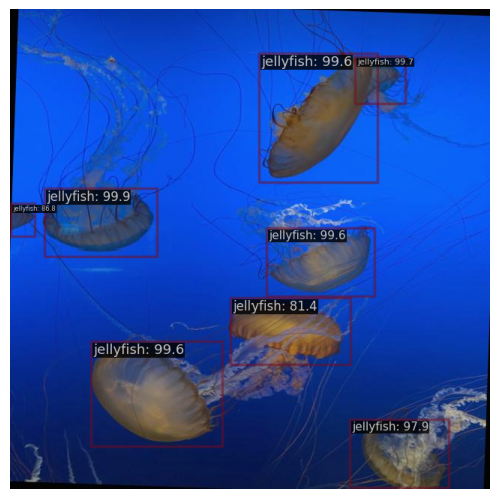

In [6]:
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
import mmcv
register_all_modules()
config_file = 'MyTutorial/my_coco_config.py'
checkpoint_file = 'MyTutorial/my_coco_train/epoch_12.pth'
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'

image = mmcv.imread( "data/mycoco/fish_voc2coco/my_coco/test/IMG_2576_jpeg_jpg.rf.22cfa500e32e9cb1427cf02ec22dd566.jpg")
image = mmcv.imconvert(image,'bgr','rgb')
result = inference_detector(model, image)


# # Init visualizer
# from mmdet.registry import VISUALIZERS
# try:
#     visualizer = VISUALIZERS.build(model.cfg.visualizer)
# except:
#     from mmengine.visualization import Visualizer
#     visualizer = Visualizer.get_current_instance()

from mmdet.visualization import DetLocalVisualizer
visualizer = DetLocalVisualizer(
    vis_backends=[dict(type='LocalVisBackend')],
    save_dir=None,
    alpha= 0.5)

visualizer.dataset_meta = model.dataset_meta

visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt = None,
    show=None,
    wait_time=0,
)
visualizer.show()

## 3.2 简单评估

In [4]:
# 批量测试用无标注图片，使用 tools/dataset_converters/images2coco.py
# 当然也可以直接for循环遍历图片列表 inference_detector
!python tools/dataset_converters/images2coco.py -h

usage: images2coco.py [-h] [-e EXCLUDE_EXTENSIONS [EXCLUDE_EXTENSIONS ...]]
                      img_path classes out

Convert images to coco format without annotations

positional arguments:
  img_path              The root path of images
  classes               The text file name of storage class list
  out                   The output annotation json file name, The save dir is
                        in the same directory as img_path

optional arguments:
  -h, --help            show this help message and exit
  -e EXCLUDE_EXTENSIONS [EXCLUDE_EXTENSIONS ...], --exclude-extensions EXCLUDE_EXTENSIONS [EXCLUDE_EXTENSIONS ...]
                        The suffix of images to be excluded, such as "png" and
                        "bmp"


In [7]:
!python tools/test.py  -h

usage: test.py [-h] [--work-dir WORK_DIR] [--out OUT] [--show]
               [--show-dir SHOW_DIR] [--wait-time WAIT_TIME]
               [--cfg-options CFG_OPTIONS [CFG_OPTIONS ...]]
               [--launcher {none,pytorch,slurm,mpi}] [--local_rank LOCAL_RANK]
               config checkpoint

MMDet test (and eval) a model

positional arguments:
  config                test config file path
  checkpoint            checkpoint file

optional arguments:
  -h, --help            show this help message and exit
  --work-dir WORK_DIR   the directory to save the file containing evaluation
                        metrics
  --out OUT             dump predictions to a pickle file for offline
                        evaluation
  --show                show prediction results
  --show-dir SHOW_DIR   directory where painted images will be saved. If
                        specified, it will be automatically saved to the
                        work_dir/timestamp/show_dir
  --wait-time WAIT_TIME
  

In [9]:
# 批量推理
!python tools/test.py MyTutorial/my_coco_train/my_coco_config.py MyTutorial/my_coco_train/epoch_12.pth \
--work-dir MyTutorial --out ./MyTutorial/my_coco_test.pkl

11/14 15:45:51 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1988052108
    GPU 0: NVIDIA GeForce RTX 3080
    CUDA_HOME: /usr/local/cuda-11.5
    NVCC: Cuda compilation tools, release 11.5, V11.5.50
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=s

In [11]:
# 简单的结果评估
!python tools/analysis_tools/eval_metric.py MyTutorial/my_coco_config.py MyTutorial/my_coco_test.pkl


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
11/14 16:02:15 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.09s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.956
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.835
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.743
 Av

In [13]:
# 混淆矩阵
!python tools/analysis_tools/confusion_matrix.py MyTutorial/my_coco_config.py MyTutorial/my_coco_test.pkl MyTutorial/  --show

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 467/467, 2434.3 task/s, elapsed: 0s, ETA:     0sFigure(720x576)


# 作业 🎇

恭喜你完成全流程！这里有几个小挑战能帮助你更好的掌握知识：

一、完成前半部分中提到的二周目，尽量依靠回忆，在不参考jupyter-notebook的基础上独立用.py文件复现全过程。

二、用官方给的coco数据集完成二周目后，说说看为什么最后的结果有那么大差距？为什么这个notebook中最后的混淆矩阵大部分数据看起来很好？

三、（选做）完成实例分割jupyter-notebook的全部内容，说说看整体流程与单纯的目标检测对比差别在哪。

祝你完成愉快！😸 